<a href="https://colab.research.google.com/github/avitripathi15/starter-hugo-academic/blob/master/flower_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Initially we transfer required libraries for image processing and training our algorithm for recognising flower**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
import pathlib

**Uploading The Data Set**

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

228827136/228813984 [==============================] - 1s 0us/step
3670


**Checking the content of the uploaded dataset**

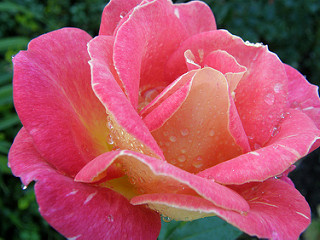

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

**Redefining the size of the images and making clusters of images for processing**

In [ ]:
batch_size = 32
img_height = 225
img_width = 225

**Dividing the dataset into training data to traing the algorithm and test data (Validation) to test our algorithm we usually use 20% of data to train our algorithm**

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


**Defining the classification of flowers according to the folder name in the dataset and Checking the classification of flowers**

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


**Plotting the figures to show the first nine images of the training data**

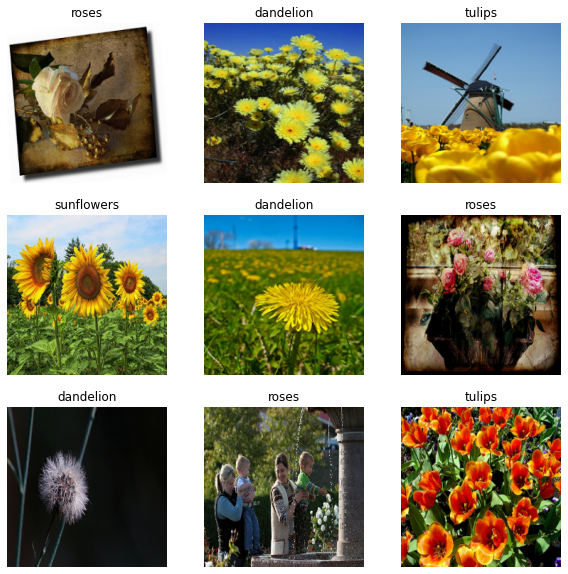

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Normalizing the RBG channel layers of the images from 0 to 255 to get them between 0 and 1 .**

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


**Using data augmentation to increase the size of training dataset by using random transformed data from the training data to introduce the model to more aspect and generalise the results better**

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

**We use sequential modelling since we have plain stack of layers for convolution and one input and output tensor**

For the given model we use 2 convolution layer with filter size to be 64 with maximum pooling and Relu activation function.
we resize the image to 64x64 

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=[64,64,3]),
  layers.MaxPooling2D(pool_size=2,strides=2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2 , strides=2),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='softmax')
])

**After experimenting with ,ultiple optimizer such as SGD, RMSprop and Adam and observed better performance with Adam optimizer**

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 225, 225, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 225, 225, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 225, 225, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

**Running the model for training and test data for 15 epoches**

In [ ]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


92/92 [==============================] - 382s 4s/step - loss: 1.4934 - accuracy: 0.4237 - val_loss: 1.0808 - val_accuracy: 0.5749
Epoch 2/15
92/92 [==============================] - 376s 4s/step - loss: 1.1648 - accuracy: 0.5177 - val_loss: 1.1591 - val_accuracy: 0.5695
Epoch 3/15
92/92 [==============================] - 373s 4s/step - loss: 1.0654 - accuracy: 0.5858 - val_loss: 1.1150 - val_accuracy: 0.5654
Epoch 4/15
92/92 [==============================] - 370s 4s/step - loss: 0.9851 - accuracy: 0.6172 - val_loss: 1.0279 - val_accuracy: 0.6213
Epoch 5/15
92/92 [==============================] - 370s 4s/step - loss: 0.9177 - accuracy: 0.6434 - val_loss: 0.9583 - val_accuracy: 0.6226
Epoch 6/15
92/92 [==============================] - 372s 4s/step - loss: 0.8574 - accuracy: 0.6737 - val_loss: 0.8341 - val_accuracy: 0.6730
Epoch 7/15
92/92 [==============================] - 370s 4s/step - loss: 0.8304 - accuracy: 0.6904 - val_loss: 0.8187 - val_accuracy: 0.7044
Epoch 8/15
92/92 [======

**Checking the test and training data by plotting a graph for training and test data for Accuraccy and Validation loss**

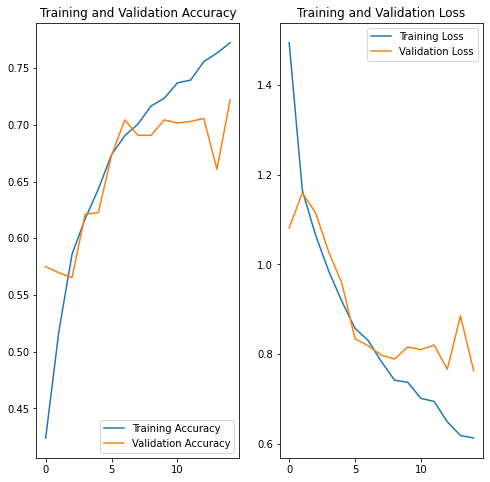

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Running the model for training and test data for 30 epoches**

In [ ]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


92/92 [==============================] - 358s 4s/step - loss: 1.6286 - accuracy: 0.4281 - val_loss: 1.1301 - val_accuracy: 0.5272
Epoch 2/30
92/92 [==============================] - 353s 4s/step - loss: 1.1569 - accuracy: 0.5450 - val_loss: 1.1216 - val_accuracy: 0.5409
Epoch 3/30
92/92 [==============================] - 356s 4s/step - loss: 1.0465 - accuracy: 0.5960 - val_loss: 0.9798 - val_accuracy: 0.6240
Epoch 4/30
92/92 [==============================] - 356s 4s/step - loss: 0.9757 - accuracy: 0.6185 - val_loss: 0.9500 - val_accuracy: 0.6308
Epoch 5/30
92/92 [==============================] - 356s 4s/step - loss: 0.8890 - accuracy: 0.6604 - val_loss: 0.8616 - val_accuracy: 0.6744
Epoch 6/30
92/92 [==============================] - 355s 4s/step - loss: 0.8492 - accuracy: 0.6785 - val_loss: 0.8604 - val_accuracy: 0.6649
Epoch 7/30
92/92 [==============================] - 356s 4s/step - loss: 0.8020 - accuracy: 0.6894 - val_loss: 0.7698 - val_accuracy: 0.6989
Epoch 8/30
92/92 [======

**Checking the test and training data by plotting a graph for training and test data for Accuraccy and Validation loss for 30 epoches**

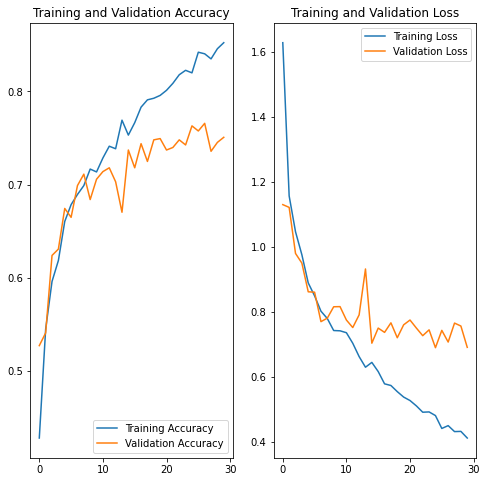

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **References**



1.   https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks

2.   https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=KwQtSOz0VrVX

3.   https://keras.io






